# 06 Mesh reordering

In [1]:
import numpy as np
import scipy.sparse as sps
import scipy as sp

In [2]:
# Create a dull square mesh
a = 0
b = 1

Nx = 4
Ny = 6

x = np.linspace( a,b, Nx )
y = np.linspace( a,b, Ny )

# X, Y = np.meshgrid( x, y, indexing = 'ij' ) # matrix indexing
X, Y = np.meshgrid( x, y, indexing = 'xy' ) # cartesian indexing

Points = np.hstack( (X.reshape(-1,1),Y.reshape(-1,1)) )

# CList is a bit more difficult but you don't need
# to worry about this: we are just creating an example
# quadrettification
C = np.arange( Nx * ( Ny - 1 ) ).reshape(-1,Nx)[:,:Nx-1].reshape(-1,1) + np.array([0,1,Nx,Nx+1])
# triangulation
CList = np.vstack((C[:,:-1],C[:,1:]))

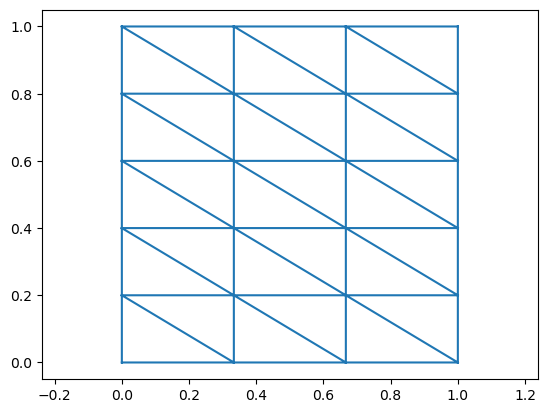

In [3]:
# show mesh
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')

plt.triplot( Points[:,0], Points[:,1], triangles = CList )
plt.show()

In [4]:
def simplexQuadrature( N, D ):
# Created by Greg von Winckel, translated in Python by Franco Zivcovich.
#
# Original code: 
# https://www.mathworks.com/matlabcentral/fileexchange/9435-n-dimensional-simplex-quadrature
#
# Translation in Julia:
# https://github.com/eschnett/SimplexQuad.jl
#
        def rquad( N, d ):
            #
            cof = 2 * np.array( range( N ) ) + d
            if d:
                A = ( d ** 2 ) / ( cof * ( cof + 2 ) )
            else:
                A = np.zeros( N )
            B = ( cof[1:] ** 2 - d ** 2 ) / ( 2 * cof[1:] * np.sqrt( cof[1:]**2 - 1 ) )
            M = np.diag( A ) + np.diag( B, -1 ) + np.diag( B, 1 )
            #
            x, V = np.linalg.eig( M )
            i = np.argsort( x )
            x = ( x[ i ] + 1 ) / 2
            w = V[ 0,i ]**2 / ( d + 1 )
            return x, w
        #
        X = np.ones( ( N ** D, D + 1 ) )
        W = np.ones( ( N ** D, ) )
        dim = np.ones( D, dtype = 'int32' )
        dim[0] = -1
        for d in range( 1, D + 1 ):
            # cornerstone of this implementation
            x, w = rquad( N, D - d )
            # some auxiliary arrays
            transposition = np.array( range( D ), dtype = 'int32' )
            transposition[ d - 1 ] = 0
            transposition[ 0 ] = d - 1
            tilation = np.ones( D, dtype = 'int32' ) * N
            tilation[ d - 1 ] = 1
            # create the structures you need
            x = np.transpose( x.reshape( dim ), transposition )
            w = np.transpose( w.reshape( dim ), transposition )
            # build X and W
            X[ :,d ] = X[ :,d-1 ] * np.tile( x, tilation ).reshape( -1, order = 'F' )
            W        = W          * np.tile( w, tilation ).reshape( -1, order = 'F' )

        # manipulate output
        X = - np.diff( X,1,1 )
        permutation = np.roll( np.array( range( D ), dtype = 'int32' ),1 )
        X = X[:,permutation]

        return X, W

In [5]:
def mesh_renumbering( Points, CList ):
    
        Nv     = Points.shape[0]
        Nc     =  CList.shape[0]
        d_elem =  CList.shape[1] - 1

        i = np.kron( np.ones( ( 1,CList.shape[1] ), dtype = 'int64' ), CList ).reshape(-1,order='F')
        j = np.kron( CList, np.ones( ( 1,CList.shape[1] ), dtype = 'int64' ) ).reshape(-1,order='F')
        id = np.argwhere( i != j ).reshape(-1)
        C = sps.csc_matrix( ( np.ones( id.shape, dtype = bool ), ( i[id], j[id] ) ), dtype = bool ).tocoo()
        i = C.row
        j = C.col
        vertexDegree = np.bincount( i, np.ones( i.shape, dtype = bool ), Nv )

        where_j = np.hstack( ( 0, 1 + np.argwhere( np.diff( j ) ).reshape(-1), j.shape[0] ) ).astype('int64')
        c = np.ones ( Nv, dtype = bool )

        Q = np.zeros( Nv, dtype = 'int64' )
        starting_vertex = np.argmin( vertexDegree )

        count = 0
        Q[ count ] = starting_vertex
        c[ Q[ count ] ] = False

        head = -1
        while ( count < Nv - 1 ):
            head = head + 1
            adj = i[ where_j[ Q[head] ] : where_j[ Q[head] + 1 ] ];
            id = np.argsort( vertexDegree[ adj ], kind='stable' )
            for k in range( adj.shape[0] ):
                if c[ adj[ id[ k ] ] ]:
                    count = count + 1
                    Q[ count ] = adj[ id[k] ]
                    c[ Q[ count ] ] = False

        reverseCMK = True
        if reverseCMK:
            Q = np.flip( Q )

        Points = Points[ Q,: ]

        iQ = np.empty_like( Q )
        iQ[Q] = np.arange( Q.size )
        CList = iQ[ CList.reshape(-1) ].reshape( CList.shape )
        
        return Points, CList

In [6]:
def gradphi( d,x ):
    # gradient of the basis function
    return np.hstack( ( - np.ones( ( d,1 ) ), np.eye( d ) ) )

def phi( d,x ):
    # basis function
    return np.eye( d + 1, 1 ).reshape(-1) + x @ gradphi( d,x )

In [7]:
def mass_assembly( Points, CList, dtB ):
    
    Nv     = Points.shape[0]
    Nc     =  CList.shape[0]
    d_elem =  CList.shape[1] - 1

    i = np.kron( np.ones( ( 1,CList.shape[1] ), dtype = 'int64' ), CList ).reshape(-1,order='F')
    j = np.kron( CList, np.ones( ( 1,CList.shape[1] ), dtype = 'int64' ) ).reshape(-1,order='F')

    X, W = simplexQuadrature( 2, d_elem )
    mass = np.zeros( ( Nc, CList.shape[1], CList.shape[1] ) )
    for q in range( W.shape[0] ):
        N0 = phi( d_elem, X[q,:][None,:] )
        mass = mass + ( N0.T @ N0 ) * ( dtB * W[q] )[:,None,None]
    M = sps.csr_matrix( ( mass.reshape(-1,order='F'), ( i, j ) ), shape = ( Nv, Nv ), dtype = np.float64 )

    return M

4

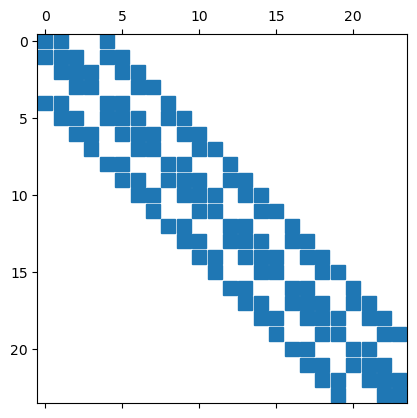

In [8]:
B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B )

# Assemble mass
M   = mass_assembly( Points, CList, np.abs( dtB ) )
plt.spy( M, precision = 'present' )

# compute bandwidth
[ i,j,s ] = sps.find( M )
np.max( np.abs( i - j ) )

4

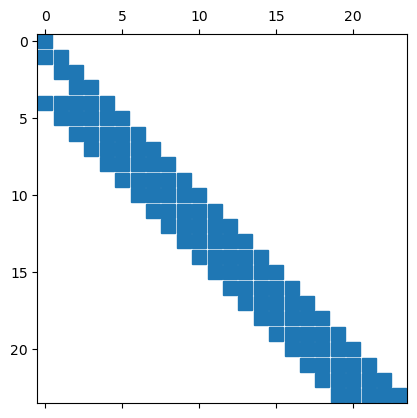

In [9]:
# Assemble mass Cholesky
L = sp.linalg.cholesky( M.toarray(), lower=True )
plt.spy( sps.csr_matrix( L ), precision = 'present' )

# compute bandwidth
[ i,j,s ] = sps.find( L )
np.max( np.abs( i - j ) )

4

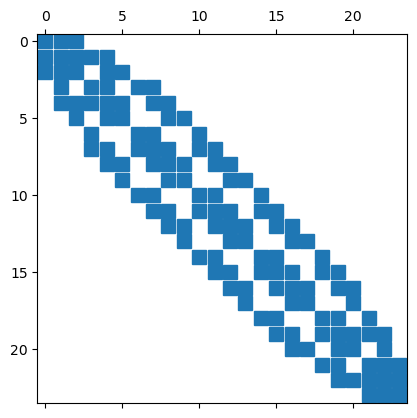

In [10]:
Points, CList = mesh_renumbering( Points, CList )
B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B )

# Assemble mass
M   = mass_assembly( Points, CList, np.abs( dtB ) )
plt.spy( M, precision = 'present' )

# compute bandwidth
[ i,j,s ] = sps.find( M )
np.max( np.abs( i - j ) )

4

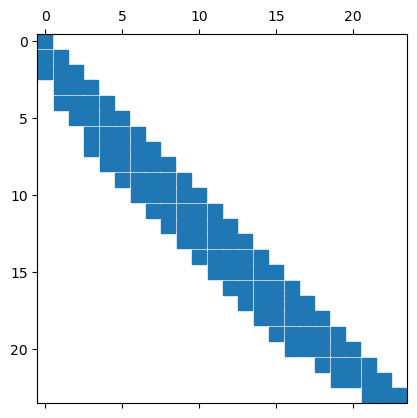

In [11]:
# Assemble mass Cholesky
L = sp.linalg.cholesky( M.toarray(), lower=True )
plt.spy( sps.csr_matrix( L ), precision = 'present' )

# compute bandwidth
[ i,j,s ] = sps.find( L )
np.max( np.abs( i - j ) )

23

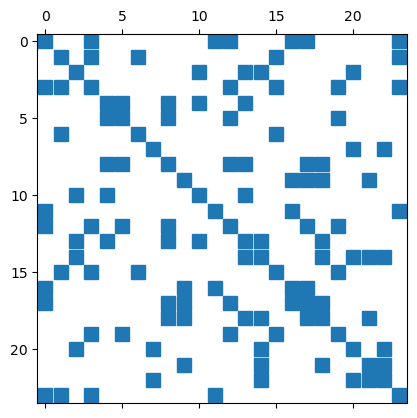

In [12]:
# shuffle Points with random permutation
Nv = Points.shape[0]
Q = np.random.permutation(np.unique(CList))
Points = Points[ Q,: ]
iQ = np.empty_like( Q )
iQ[Q] = np.arange( Q.size )
CList = iQ[ CList.reshape(-1) ].reshape( CList.shape )

B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) )
dtB = np.linalg.det( B )

# Assemble mass
M   = mass_assembly( Points, CList, np.abs( dtB ) )
plt.spy( M, precision = 'present' )

# compute bandwidth
[ i,j,s ] = sps.find( M )
np.max( np.abs( i - j ) )

23

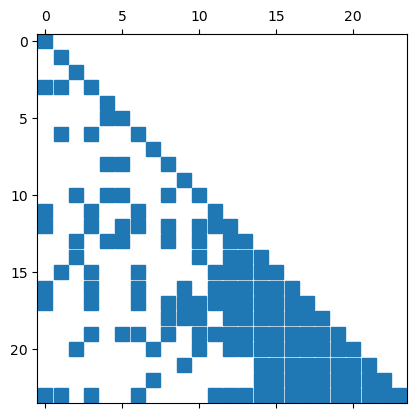

In [13]:
# Assemble mass Cholesky
L = sp.linalg.cholesky( M.toarray(), lower=True )
plt.spy( sps.csr_matrix( L ), precision = 'present' )

# compute bandwidth
[ i,j,s ] = sps.find( L )
np.max( np.abs( i - j ) )